# HBV Calibration

## Setup and Data Preparation

In [17]:
#some general python and eWaterCycle libraries need to be imported
%matplotlib inline
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import display
import xarray as xr
from scipy.stats import wasserstein_distance

# Niceties
from rich import print
from tqdm import tqdm


# General eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing
from ewatercycle.forcing import sources
from ewatercycle.models import HBV

# Optional: Data Assimilation
# If not installed, uncomment below to install
# !pip install ewatercycle-da
from ewatercycle_DA import DA

## Choose region and time period

<Axes: >

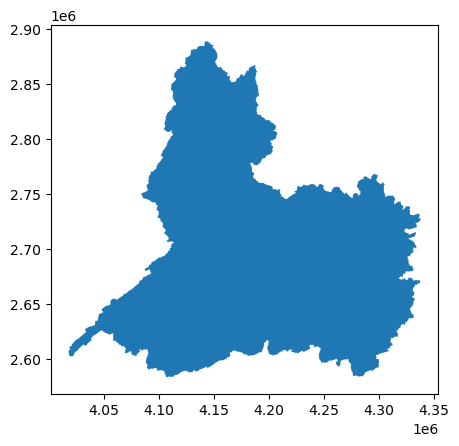

In [2]:
# name of the catchment
basin_name = "FR000119"

# defining dates for calibration
experiment_start_date = "2013-11-26T00:00:00Z"
experiment_end_date = "2019-12-31T00:00:00Z"

#Define Catchment Area
shapefile_path = Path.home() / "BEP-Elke" / "book" / "thesis_projects" / "BSc" / "2025_Q4_ElkeSchokking_CEG" / "work in progress" / "ShapefilesFR000119" / "FR000119.shp"

#check
catchment = gpd.read_file(shapefile_path)
catchment = catchment.to_crs(epsg=3035)
catchment["area_km2"] = catchment.geometry.area / 1e6  
basin_area = catchment["area_km2"].sum()
catchment.plot()

In [3]:
# Location forcing files in home directory
forcing_path = Path.home() / "forcing" / "FR000119"/"ERA5"
forcing_path.mkdir(parents=True, exist_ok=True)

## Generate ERA 5 Forcing

In [4]:
# Option one: generate forcing:
#ERA5_forcing = sources["LumpedMakkinkForcing"].generate(
    #dataset="ERA5",
    #start_time=experiment_start_date,
    #end_time=experiment_end_date,
    #shape=shapefile_path,
#)

# Option two: Load generated (merged) data
forcing_dir = Path("/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in progress/esmvaltool_output/ewcrep5yvtlv4f_20250525_104347/work/diagnostic/script")
ERA5_forcing = sources["LumpedMakkinkForcing"].load(directory=forcing_dir)

## Defining historical data from eStreams
The original CSV file had some formatting and encoding issues—like strange quotation marks and all the data crammed into a single column—which made it impossible to load with the usual pandas.read_csv() method. To work around this, I used a custom parser to manually extract the dates and discharge values.

In [5]:
# Manually parse the file
dates = []
discharges = []

with open("A3550050.csv", "r", encoding="utf-8") as f:
    next(f)
    for line in f:
        parts = line.replace('""', '"').strip().split(',"')
        if len(parts) >= 2:
            date_str = parts[0].strip('"')
            discharge_str = parts[1].strip('"')
            try:
                dates.append(pd.to_datetime(date_str))
                discharges.append(float(discharge_str))
            except ValueError:
                continue

discharge_series = pd.Series(discharges, index=dates, name="Discharge (m³/s)")
Q_obs = discharge_series[experiment_start_date:experiment_end_date]

## Ensemble Initialization and Parameter Sampling

In [6]:
# Define HBV parameter bounds and names
param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]
p_min = np.array([0.0,  0.2,   40.0,  0.5,   0.001,   1.0,   0.01,  0.0001,  0.01])
p_max = np.array([8.0,  1.0,  800.0,  4.0,   0.3,    10.0,   0.1,   0.01,   10.0])

n_particles = 1000  # ensemble size
# Sample random parameters for each particle within bounds
parameters = np.zeros((len(param_names), n_particles))
for j in range(len(param_names)):
    parameters[j, :] = np.random.uniform(p_min[j], p_max[j], size=n_particles)

In [7]:
# Create ensemble and initialize each member with HBV model and unique parameters
ensemble = DA.Ensemble(N=n_particles)
ensemble.setup()  # set up the ensemble environment

# Prepare setup arguments for each particle (each gets its parameter set)
setup_kwargs_list = [{'parameters': parameters[:, i]} for i in range(n_particles)]

# Initialize all ensemble members with the HBVLocal model, forcing data, and parameters
ensemble.initialize(model_name=["HBVLocal"] * n_particles,
                    forcing=[ERA5_forcing] * n_particles,
                    setup_kwargs=setup_kwargs_list) 

# (Optional) Choose a reference model for time tracking
ref_model = ensemble.ensemble_list[0].model

# Generate config file with first parameter set
config_file, _ = ref_model.setup(parameters=parameters[:, 0])

# Initialize model
ref_model.initialize(config_file)

## Running the Ensemble Simulation

In [8]:
# Determine number of time steps in the simulation period
n_timesteps = int((ref_model.end_time - ref_model.start_time) / ref_model.time_step)

time_index = []           # list to store timestamps for each time step
ensemble_Q_outputs = []   # list to store discharge arrays for each time step

for step in range(n_timesteps):
    # Record current model time
    current_time = pd.Timestamp(ref_model.time_as_datetime.date())
    time_index.append(current_time)
    
    # Advance all models by one time step and collect their discharge values
    ensemble.update()  # update all ensemble members by one step
    Q_values = np.array(ensemble.get_value("Q")).flatten()  # discharge of all particles
    Q_values_m3s = Q_values * basin_area * 1000 / 86400 #convert to m3/s
    ensemble_Q_outputs.append(Q_values_m3s)

# Finalize the ensemble to release resources (important if models run in containers)
ensemble.finalize()

# Convert collected outputs to a DataFrame for convenience
Q_array = np.array(ensemble_Q_outputs)        # shape: (n_timesteps, n_particles)
df_ensemble = pd.DataFrame(
    data=Q_array, 
    index=pd.DatetimeIndex(time_index), 
    columns=[f"particle_{i}" for i in range(n_particles)]
)

In [9]:
# print(df_ensemble.shape)
# print(df_ensemble.head())

## Defining the Calibration Objective

In [10]:
def calibration_objective(simulated_series: pd.Series, observed_series: pd.Series,
                          w_lognse: float = 0.7, w_emd: float = 0.3) -> float:
    """
    Calibrate model by combining:
    - log-NSE: performance during low flows
    - EMD: match drought event characteristics (timing, deficit)
    Weights w_lognse and w_emd define the importance of each.
    Lower total_score indicates better calibration.
    """

    # Align indices
    sim = simulated_series.loc[observed_series.index]
    obs = observed_series

    # 1. log-NSE
    sim_pos = sim[sim > 0]
    obs_pos = obs[obs > 0]
    common_index = sim_pos.index.intersection(obs_pos.index)
    sim_log = np.log(sim_pos.loc[common_index])
    obs_log = np.log(obs_pos.loc[common_index])
    
    numerator = np.sum((sim_log - obs_log) ** 2)
    denominator = np.sum((obs_log - np.mean(obs_log)) ** 2)
    log_nse = 1 - (numerator / denominator) if denominator != 0 else np.inf
    error_nse = 1 - log_nse  # to be minimized

    # 2. EMD from drought characteristics
    obs_droughts = droughts(obs, basin_name="obs", q_crit=500)
    sim_droughts = droughts(sim, basin_name="sim", q_crit=500)

    obs_durations = pd.DataFrame(obs_droughts)["Duration (days)"].values
    sim_durations = pd.DataFrame(sim_droughts)["Duration (days)"].values
    obs_deficits = pd.DataFrame(obs_droughts)["Max Cumulative Deficit (m3/s)"].abs().values
    sim_deficits = pd.DataFrame(sim_droughts)["Max Cumulative Deficit (m3/s)"].abs().values

    emd_duration = wasserstein_distance(obs_durations, sim_durations)
    emd_deficit = wasserstein_distance(obs_deficits, sim_deficits)
    error_emd = emd_duration + emd_deficit

    # Combine with weighted sum
    total_score = w_lognse * error_nse + w_emd * error_emd
    return total_score

In [11]:
# print("Q_obs index sample:", Q_obs.index[:3])
# print("df_ensemble index sample:", df_ensemble.index[:3])

## Evaluating Performance and Selecting the Best Parameter Set

In [13]:
from critical_days_module import droughts

Exported functions to: critical_days_module.py


In [14]:
# Evaluate objective for each ensemble member
scores = []

# Same datetime-index
Q_obs.index = Q_obs.index.normalize()
Q_obs.index = Q_obs.index.tz_localize(None)

# Slice only the overlap 
Q_obs_aligned = Q_obs.loc[df_ensemble.index.min():df_ensemble.index.max()]

for i in range(n_particles):
    sim_series = df_ensemble[f"particle_{i}"]

    if sim_series is None or sim_series.empty:
        print(f"Skipping particle_{i} (empty output)")
        scores.append(np.inf)  # Assign a bad score
        continue

    # Use the correct observation series (make sure Q_obs exists and matches in index)
    score = calibration_objective(sim_series, Q_obs_aligned)
    scores.append(score)

scores = np.array(scores)
best_index = np.argmin(scores)              # index of minimum objective value
best_score = scores[best_index]             # lowest score
best_params = parameters[:, best_index]     # parameter set corresponding to best score

print(f"Best score: {best_score:.3f} (part {best_index})")

Best score: 42.378 (part 690)

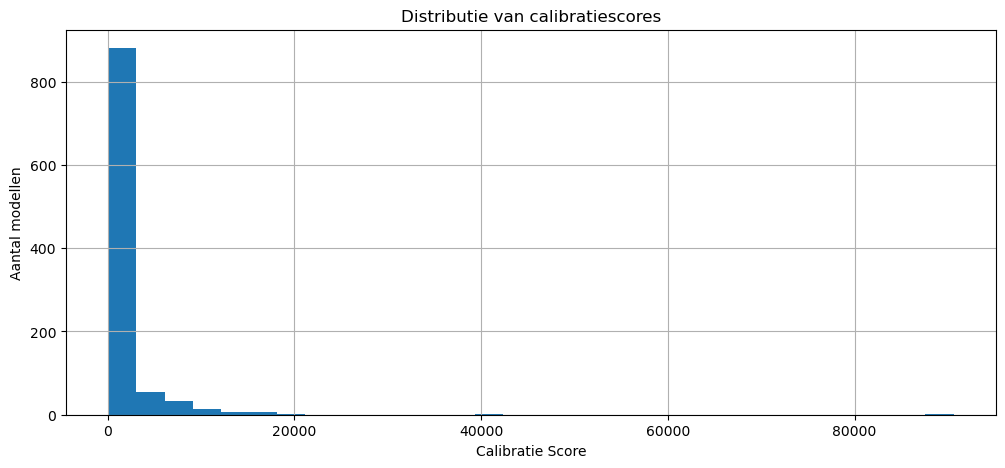

Best score: 42.378 at particle index: 690

In [15]:
# Histogram of scores
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.hist(scores, bins=30)
plt.title("Distributie van calibratiescores")
plt.xlabel("Calibratie Score")
plt.ylabel("Aantal modellen")
plt.grid(True)
plt.show()

# Print best score
print(f"Best score: {best_score:.3f} at particle index: {best_index}")

## Outputting the Optimal Parameters

In [16]:
# Print the best score and parameter set
print(f"Best objective score: {best_score:.4f}")
best_params_list = [round(val, 4) for val in best_params]
print("par_0 =", best_params_list)
print("param_names =", param_names)

Best objective score: 42.3778

par_0 =
[4.533, 0.4272, 442.0109, 1.0321, 0.0714, 8.5025, 0.0139, 0.0099, 1.085]

param_names =
['Imax', 'Ce', 'Sumax', 'Beta', 'Pmax', 'Tlag', 'Kf', 'Ks', 'FM']

In [18]:
# Print best score
print(f"Best objective score: {best_score:.4f}")

# Round best parameters
best_params_list = [round(val, 4) for val in best_params]

# Define parameter descriptions (must match param_names)
param_descriptions = [
    "Maximum intensity",
    "Coefficient of evaporation",
    "Field capacity",
    "Shape coefficient",
    "Maximum percolation rate",
    "Time lag",
    "Fast run-off parameter",
    "Slow run-off parameter",
    "Degree-day factor"
]

# Build DataFrame
df_params = pd.DataFrame({
    "Parameter": param_names,
    "Description": param_descriptions,
    "Value": best_params_list
})

# Reset index and drop it for clean display
df_params.index = [""] * len(df_params)

# Display the styled table
display(df_params.style.set_table_styles([
    {"selector": "th", "props": [("font-weight", "bold")]}
]))

Best objective score: 42.3778

,Parameter,Description,Value
,Imax,Maximum intensity,4.533000
,Ce,Coefficient of evaporation,0.427200
,Sumax,Field capacity,442.010900
,Beta,Shape coefficient,1.032100
,Pmax,Maximum percolation rate,0.071400
,Tlag,Time lag,8.502500
,Kf,Fast run-off parameter,0.013900
,Ks,Slow run-off parameter,0.009900
,FM,Degree-day factor,1.085000
